In [59]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [60]:
gdrive_path = '/content/drive/MyDrive/mydata'

In [51]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import pandas as pd
import string
import re
import nltk
from textblob import TextBlob
from nltk.corpus import wordnet
from nltk.metrics import edit_distance
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import pickle
import itertools
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import gensim
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [9]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [10]:
data = pd.read_csv("/balanced data.csv")
data.sample(10)

,conclusion,Abnormal
6502,Frequent posterior slow waves in wakefulness a...,1
529,The EEG showed a low voltage context rhythm wh...,0
4037,The EEG is normal.\n(11/05/2006),0
489,The EEG is within normal limits.\n(27/10/2003),0
898,This EEG is abnormal because of runs of sharp ...,1
2977,Conclusion: The EEG is probably within normal ...,0
4299,Normal EEG.\n(26/07/2006),0
2671,1) The EEG was severely abnormal.\n2) This is ...,1
4890,"1) Diffuse slow wave 6-8 Hz, more attenuated i...",1
1186,The EEG indicated normal waking and sleep back...,0


In [38]:
# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 32
BATCH_SIZE = 1024

NORMAL = 0
ABNORMAL = 1
CLASSIFICATION_THRESHOLDS = (0.4, 0.7)

KERAS_MODEL = "lstm_w2v_cbow.sav"
WORD2VEC_MODEL = "model.w2v_cbow"
TOKENIZER_MODEL = "w2v_tokenizer_cbow.pkl"
ENCODER_MODEL = "encoder_cbow.pkl"

In [12]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [14]:
# TEXT CLEANING
TEXT_CLEANING = "@\S+|https?:\S+|http?:\S|[^A-Za-z]+"

def preprocess(text, stem=False):

    text = re.sub(TEXT_CLEANING, ' ', str(text).lower()).strip()
    tokens = []

    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)

    return " ".join(tokens)

In [15]:
data.conclusion = data.conclusion.apply(lambda x: preprocess(x))

In [16]:
data.sample(10)

,conclusion,Abnormal
6339,eeg customary,0
879,eeg showed diffuse cortical dysfunction,1
1166,eeg improved epileptiform activity seen occasi...,1
4252,eeg showed absence normal background activitie...,1
3642,eeg within normal limits,0
1824,eeg within normal frontiers,0
1987,eeg within normal limits,0
828,eeg makedly abnormal presence diffuse theta de...,1
4837,normal eeg,0
5415,background normal frequent short burst l tempo...,1


In [17]:
X = data["conclusion"].values
y = data["Abnormal"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
documents = [_text.split() for _text in data.conclusion]
print(len(documents))

6624


In [19]:
cbow_w2v = gensim.models.Word2Vec(documents, vector_size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=8, sg=0)

In [20]:
words = cbow_w2v.wv.index_to_key
vocab_size_wv = len(words)
print("Vocab size:", vocab_size_wv)

Vocab size: 476


In [21]:
cbow_w2v.wv.most_similar("abnormal")

[('bitemporal', 0.9792208075523376),
 ('intermittent', 0.9730948209762573),
 ('mildly', 0.9665433764457703),
 ('frontotemporal', 0.9603422284126282),
 ('seen', 0.9558606147766113),
 ('side', 0.9506126642227173),
 ('independent', 0.949182391166687),
 ('slow', 0.9460313320159912),
 ('central', 0.9448767900466919),
 ('r', 0.9433795213699341)]

In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.conclusion)

In [23]:
vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 2264


In [24]:
x_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=SEQUENCE_LENGTH)

In [25]:
encoder = LabelEncoder()
encoder.fit(data.Abnormal.tolist())
y_train = encoder.transform(y_train.tolist())
y_test = encoder.transform(y_test.tolist())
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (5299, 1)
y_test (1325, 1)


In [26]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (5299, 300)
y_train (5299, 1)

x_test (1325, 300)
y_test (1325, 1)


In [27]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
 if word in cbow_w2v.wv:
    embedding_matrix[i] = cbow_w2v.wv[word]
print(embedding_matrix.shape)

(2264, 300)


In [28]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [63]:
cbow_model = Sequential()
cbow_model.add(embedding_layer)
cbow_model.add(Dropout(0.5))
cbow_model.add(Bidirectional(LSTM(50, dropout=0.2, recurrent_dropout=0.2)))
cbow_model.add(Dense(1, activation='sigmoid'))
cbow_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          679200    
                                                                 
 dropout_1 (Dropout)         (None, 300, 300)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 100)               140400    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 819701 (3.13 MB)
Trainable params: 140501 (548.83 KB)
Non-trainable params: 679200 (2.59 MB)
_________________________________________________________________


In [64]:
cbow_model.compile(loss='binary_crossentropy',
                    optimizer="adam",
                    metrics=["accuracy"])

In [65]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [66]:
history = cbow_model.fit(x_train, y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_split=0.1,
                         verbose=1,
                         callbacks=callbacks)

cbow_model.save(KERAS_MODEL)
cbow_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

Epoch 1/32
5/5 [==============================] - 15s 2s/step - loss: 0.6089 - accuracy: 0.8207 - val_loss: 0.4640 - val_accuracy: 0.9358 - lr: 0.0010
Epoch 2/32
5/5 [==============================] - 8s 2s/step - loss: 0.4262 - accuracy: 0.9440 - val_loss: 0.3052 - val_accuracy: 0.9472 - lr: 0.0010
Epoch 3/32
5/5 [==============================] - 9s 2s/step - loss: 0.2877 - accuracy: 0.9522 - val_loss: 0.1964 - val_accuracy: 0.9623 - lr: 0.0010
Epoch 4/32
5/5 [==============================] - 9s 2s/step - loss: 0.1946 - accuracy: 0.9579 - val_loss: 0.1323 - val_accuracy: 0.9642 - lr: 0.0010
Epoch 5/32
5/5 [==============================] - 9s 2s/step - loss: 0.1475 - accuracy: 0.9629 - val_loss: 0.1074 - val_accuracy: 0.9717 - lr: 0.0010
Epoch 6/32
5/5 [==============================] - 9s 2s/step - loss: 0.1284 - accuracy: 0.9633 - val_loss: 0.1035 - val_accuracy: 0.9717 - lr: 0.0010
Epoch 7/32
5/5 [==============================] - 9s 2s/step - loss: 0.1232 - accuracy: 0.9639 - va

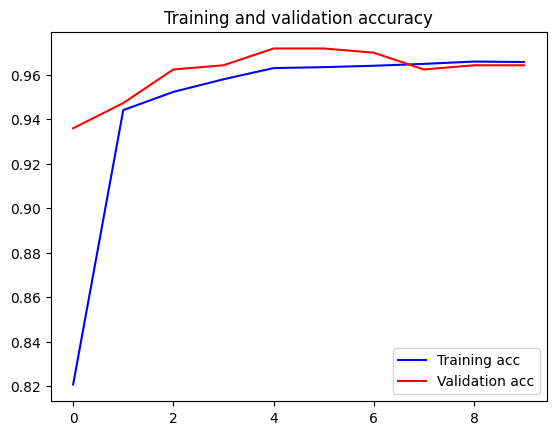

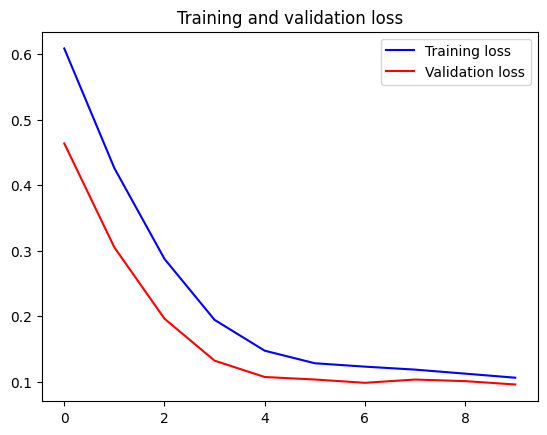

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [68]:
%%time
score = cbow_model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

2/2 [==============================] - 0s 172ms/step - loss: 0.0980 - accuracy: 0.9691

ACCURACY: 0.9690566062927246
LOSS: 0.09799612313508987
CPU times: user 420 ms, sys: 40.2 ms, total: 460 ms
Wall time: 689 ms


In [69]:
def decode_prediction(score):
  return NORMAL if score < 0.5 else ABNORMAL

In [70]:
%%time
y_pred_1d = []
y_test_1d = list(y_test)
scores = cbow_model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_prediction(score) for score in scores]

1/1 [==============================] - 1s 679ms/step
CPU times: user 663 ms, sys: 77.9 ms, total: 741 ms
Wall time: 736 ms


In [52]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title, fontsize=30)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
  plt.yticks(tick_marks, classes, fontsize=22)

  fmt = '.2f'
  thresh = cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

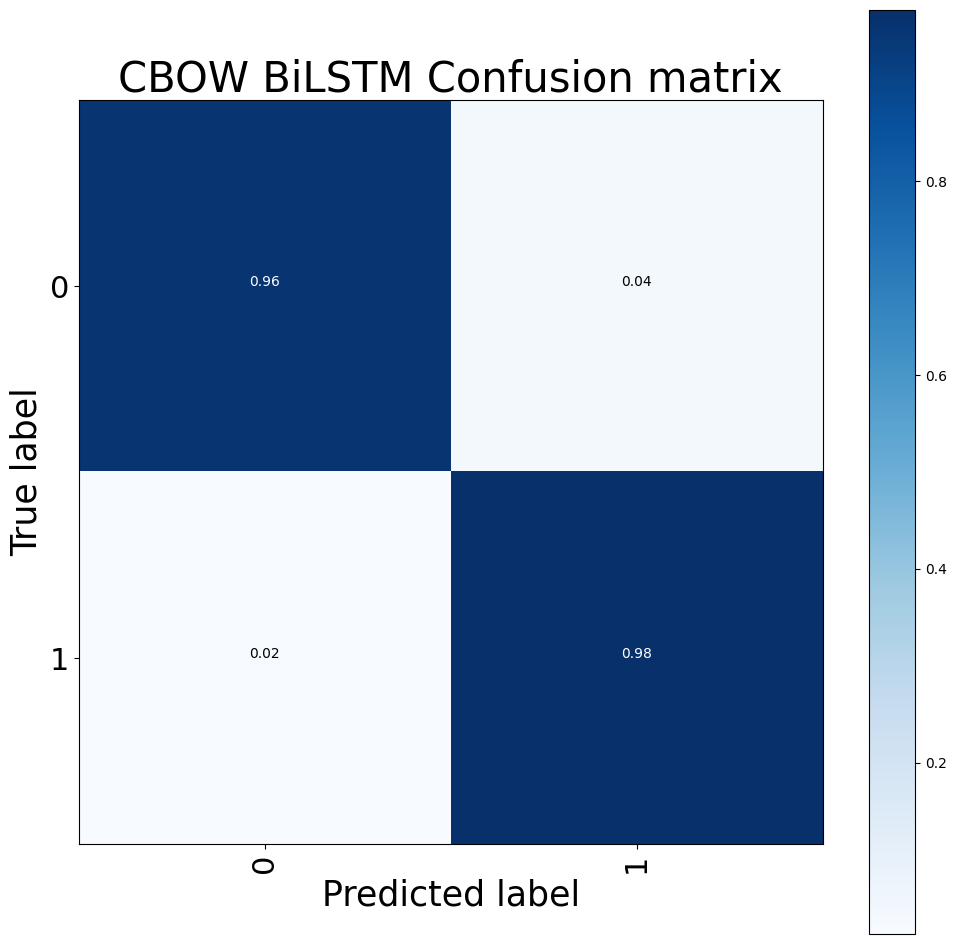

CPU times: user 331 ms, sys: 272 ms, total: 603 ms
Wall time: 335 ms


In [71]:
%%time
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=np.unique(y_train), title="CBOW BiLSTM Confusion matrix")
plt.show()

In [72]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       641
           1       0.96      0.98      0.97       684

    accuracy                           0.97      1325
   macro avg       0.97      0.97      0.97      1325
weighted avg       0.97      0.97      0.97      1325



In [73]:
accuracy_score(y_test_1d, y_pred_1d)

0.9690566037735849

In [74]:
cbow_model.save(f"{gdrive_path}{KERAS_MODEL}")
cbow_w2v.save(f"{gdrive_path}{WORD2VEC_MODEL}")
pickle.dump(tokenizer, open(f"{gdrive_path}{TOKENIZER_MODEL}", "wb"), protocol=0)
pickle.dump(encoder, open(f"{gdrive_path}{ENCODER_MODEL}", "wb"), protocol=0)

In [62]:
# download the trained model
import shutil
shutil.make_archive("/content/drive/MyDrive/mydata", 'zip', "/content/drive/MyDrive/mydata")
from google.colab import files
files.download("/content/drive/MyDrive/mydata.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>